# Первичная обработка данных
Открываем файл *train.csv*, приводим имена к нижнему регистру, удаляем дубликаты строк, заполняем пустые ячейки столбца *age* нормальным распределением

In [24]:
import pandas as pd
import numpy as np

# Читаем данные из CSV файла
tableData = pd.read_csv(r'D:\TESTS\Tests from ITECO\train.csv')

# Приводим все имена к нижнему регистру и убираем пробелы по краям
tableData['Name'] = tableData['Name'].str.strip().str.lower()

# Создаем копию DataFrame, чтобы избежать предупреждений Pandas
Tnew = tableData.copy()

# Удаление дублей и подсчет удаленных
m = Tnew.shape[0]
Tnew = Tnew.drop_duplicates()
mn = Tnew.shape[0]
print(f'Удалено дубликатов: {m - mn}')

# Находим пропущенные значения
missing = Tnew.isna()


# Считаем сумму пропущенных по каждому столбцу
sumMissing = missing.sum()

# Выведим пропущенные по всем столбцам
print(sumMissing)

# Общее число пропущенных значений
totalMissing = sumMissing.sum()

# Строки с пропущенными значениями
rowsWithMissing = missing.any(axis=1)

# Строки с пропусками
tableWithMissing = Tnew.loc[rowsWithMissing, :]





# Заполним возраст по нормальному распределению
mean_Age = Tnew['Age'].mean()
std_Age = Tnew['Age'].std()

# Количество пропусков
num_missing = Tnew['Age'].isna().sum()

# Генерация случайных значений
random_ages = np.random.normal(mean_Age, std_Age, num_missing)

# Ограничение по логике данных, например, возраст не может быть меньше 0 или менее 13
random_ages = np.clip(random_ages, 13, 87)

# Заполнение пропусков
Tnew.loc[Tnew['Age'].isna(), 'Age'] = random_ages



Удалено дубликатов: 158
Name                  1352
Age                   1306
Gender                1348
Blood Type            1279
Medical Condition        0
Date of Admission     1328
Doctor                1299
Hospital              1389
Insurance Provider       0
Billing Amount           0
Room Number           1362
Admission Type        1369
Discharge Date        1294
Medication            1356
Test Results          1316
dtype: int64


# Заполнение пропусков пола исходя из имени

In [25]:
import gender_guesser.detector as gender

detector = gender.Detector()

import re

def get_gender(full_name):
    if pd.isna(full_name):
        return None
    full_name = full_name.lower()
    full_name = re.sub(r'\b(mr|mrs|ms|dr|md)\.?', '', full_name)
    parts = full_name.strip().split()
    if not parts:
        return None
    first_name = parts[0].capitalize()
    gender_pred = detector.get_gender(first_name)
    if gender_pred in ['male', 'mostly_male']:
        return 'male'
    elif gender_pred in ['female', 'mostly_female']:
        return 'female'
    elif gender_pred in ['andy', 'unknown']:
        return 'unknown'  # вместо None, чтобы явно показать неопределённость
    else:
        return 'unknown'




Tnew['Gender'] = Tnew['Name'].apply(get_gender)

gender_probs = Tnew['Gender'].value_counts(normalize=True, dropna=True)

# Функция для случайного заполнения пола по распределению
def fill_gender_prob(row):
    if pd.isna(row['Gender']):
        return np.random.choice(gender_probs.index, p=gender_probs.values)
    else:
        return row['Gender']

Tnew['Gender'] = Tnew.apply(fill_gender_prob, axis=1)
#print(Tnew['Gender'])

# Вероятностное заполнение пропущенных типов крови
Для заполнения пропусков (NaN) в столбце "Blood Type" на основе вероятностного распределения типов крови, нужно сначала определить вероятности для каждого типа, а затем случайным образом заменить пропуски с учетом этих вероятностей.

Согласно статистике по распространению групп крови (примерные значения для России/Европы):

Группа крови	Процент (прибл.)
O+	35%
A+	37%
B+	12%
AB+	8%
O-	3%
A-	3%
B-	1.5%
AB-	0.5%
Используем эти вероятности для заполнения.

In [26]:

# Определяем распределение вероятностей
blood_types = ['O+', 'A+', 'B+', 'AB+', 'O-', 'A-', 'B-', 'AB-']
probabilities = [0.35, 0.37, 0.12, 0.08, 0.03, 0.03, 0.015, 0.005]

# Функция для замены NaN с учетом распределения вероятностей
def fill_blood_type_with_probability(df, column='Blood Type'):
    missing_idx = df[column].isna()
    num_missing = missing_idx.sum()
    # Генерируем случайные типы крови с заданным распределением
    fill_values = np.random.choice(blood_types, size=num_missing, p=probabilities)
    df.loc[missing_idx, column] = fill_values
    return df

Tnew = fill_blood_type_with_probability(Tnew, 'Blood Type')
print(Tnew['Blood Type'])

0         O+
1         B-
2         A+
3         B+
4        AB+
        ... 
44395     B-
44396    AB-
44397     B-
44398     A+
44399     B+
Name: Blood Type, Length: 44242, dtype: object


# Число уникальных данных
Выведим общее число уникальных значений для столбцов где это уместно и посмотрим число, чтобы увидеть кого выбивающегося из выборки (таких нет)

In [27]:
'''
# Возрасты, представленные в выборке
uniqueAge = Tnew['Age'].unique()
numuniqueAge = len(uniqueAge)
print(f'Число возрастов: {numuniqueAge}')
print('Представленные возрасты:')
print(uniqueAge)



# Типы крови
uniqueBloodType = Tnew['Blood Type'].unique()
numuniqueBloodType = len(uniqueBloodType)
print(f'Число типов крови: {numuniqueBloodType}')
print('Представленные типы крови:')
print(uniqueBloodType)


# Уникальные номера комнат
uniqueRoom = Tnew['Room Number'].unique()
numuniqueRoom = len(uniqueRoom)
print(f'Число комнат: {numuniqueRoom}')
print('Представленные комнаты:')
print(uniqueRoom)

'''




def print_unique_counts(df):
    columns = ['Medical Condition', 'Insurance Provider', 'Test Results', 'Medication', 'Admission Type','Blood Type','Gender']
    for col in columns:
        num_unique = df[col].nunique()
        counts = df[col].value_counts()
        print(f'Число уникальных значений в столбце "{col}": {num_unique}')
        print(f'Уникальные значения и количества в столбце "{col}":')
        print(counts)
        print('-' * 40)

# Вызов функции для вашего DataFrame
print_unique_counts(Tnew)




Число уникальных значений в столбце "Medical Condition": 6
Уникальные значения и количества в столбце "Medical Condition":
Medical Condition
Diabetes        7449
Hypertension    7428
Arthritis       7369
Obesity         7353
Cancer          7331
Asthma          7312
Name: count, dtype: int64
----------------------------------------
Число уникальных значений в столбце "Insurance Provider": 5
Уникальные значения и количества в столбце "Insurance Provider":
Insurance Provider
Cigna               9012
UnitedHealthcare    8899
Medicare            8861
Blue Cross          8845
Aetna               8625
Name: count, dtype: int64
----------------------------------------
Число уникальных значений в столбце "Test Results": 3
Уникальные значения и количества в столбце "Test Results":
Test Results
Abnormal        14354
Normal          14309
Inconclusive    14263
Name: count, dtype: int64
----------------------------------------
Число уникальных значений в столбце "Medication": 5
Уникальные значения

# Заполнение полей относительно пребывания и выписки
Примем гиптоезу, что люди, находящиеся на лечении с различными заболеваниями проводят там в среднем одно и тоже число дней соответственно (это грубовато, но в условиях ограниченности времени решения она вполне компетентна), добавим столбец Stay Duration чтобы не работать в дальнейшем с датами, в наших задачах они не нужны сегодня

In [28]:
import pandas as pd
Tnew['Date of Admission']
# Конвертация в datetime
Tnew['Date of Admission'] = pd.to_datetime(Tnew['Date of Admission'], errors='coerce')
Tnew['Discharge Date'] = pd.to_datetime(Tnew['Discharge Date'], errors='coerce')
Tnew['Stay Duration'] = (Tnew['Discharge Date'] - Tnew['Date of Admission']).dt.days
# Средняя длительность пребывания по болезням
average_stay = Tnew.groupby('Medical Condition')['Stay Duration'].mean()

# Функции заполнения
def fill_admission_date(row):
    if pd.isna(row['Date of Admission']) and pd.notna(row['Discharge Date']) and row['Medical Condition'] in average_stay:
        return row['Discharge Date'] - pd.Timedelta(days=average_stay[row['Medical Condition']])
    return row['Date of Admission']

def fill_discharge_date(row):
    if pd.isna(row['Discharge Date']) and pd.notna(row['Date of Admission']) and row['Medical Condition'] in average_stay:
        return row['Date of Admission'] + pd.Timedelta(days=average_stay[row['Medical Condition']])
    return row['Discharge Date']

# Применение

Tnew['Date of Admission'] = Tnew.apply(fill_admission_date, axis=1)
Tnew['Discharge Date'] = Tnew.apply(fill_discharge_date, axis=1)

# Пересчет длительности пребывания
Tnew['Stay Duration'] = (Tnew['Discharge Date'] - Tnew['Date of Admission']).dt.days


# Заполнение персональных полей и номеров комнат
Имена, название госпиталей и доктора столбцы персональные, выборка очень широкая и корреляции нет, поэтому заполним их без каких либо соответствий. 
Наврятли номер комнаты это важный фактор, так как госпитали различные. Но при более глубоком анализе возможно выстроить связь между болезнями и номерами

In [29]:
for col in ['Name', 'Hospital', 'Doctor']:
    nan_idx = Tnew[col].isna()
    count_nan = nan_idx.sum()
    fill_values = [f"{col}{i+1}" for i in range(count_nan)]
    Tnew.loc[nan_idx, col] = fill_values

Tnew['Room Number'] = Tnew['Room Number'].fillna(999)

# Заполнение пустых полей Admission Type
Существует некоторый порядок норм госпитализации больных, основанные на общепринятых медицинских стандартах (предложение от нейросети):
Arthritis, Diabetes, Obesity, Hypertension, Cancer — чаще всего характеризуются плановым (Elective) поступлением, так как лечение этих хронических заболеваний обычно планируется заранее.
Asthma — чаще всего связано с экстренным (Emergency) или срочным (Urgent) поступлением, особенно при обострениях.
Таким образом, для заполнения пропусков логично присвоить тип поступления в зависимости от болезни согласно этому правилу

In [30]:
def fill_admission_type(row):
    if pd.isna(row['Admission Type']):
        if row['Medical Condition'] in ['Asthma']:
            return 'Emergency'  # или 'Urgent', если более уместно
        elif row['Medical Condition'] in ['Arthritis', 'Diabetes', 'Obesity', 'Hypertension', 'Cancer']:
            return 'Elective'
        else:
            return 'Elective'  
    else:
        return row['Admission Type']

Tnew['Admission Type'] = Tnew.apply(fill_admission_type, axis=1)

# Заполнение поля Test Results
Воспользуемся гипотезой ИИ для заполнения результатов:
При хронических и контролируемых заболеваниях типа Arthritis, Diabetes, Obesity, Hypertension с плановым типом поступления появляется вероятность получения в основном нормальных (Normal) результатов.

При острых состояниях, например Asthma с типом поступления Emergency, повышена вероятность аномальных (Abnormal) или неокончательных (Inconclusive) результатов.

In [31]:
def fill_test_results(row):
    if pd.isna(row['Test Results']):
        if row['Medical Condition'] in ['Asthma']:
            return 'Abnormal'
        elif row['Admission Type'] == 'Emergency':
            return 'Abnormal'
        elif row['Medical Condition'] in ['Arthritis', 'Diabetes', 'Obesity', 'Hypertension', 'Cancer']:
            return 'Normal'
        else:
            return 'Inconclusive'
    else:
        return row['Test Results']

Tnew['Test Results'] = Tnew.apply(fill_test_results, axis=1)




# Заполнение полей Medications
Воспользуемся гипотезой ИИ для заполнения медикаментов:
Arthritis: часто назначают Ibuprofen (противовоспалительное)
Diabetes: могут назначать Lipitor (для контроля липидов и сердечно-сосудистых рисков)
Asthma: могут назначать Paracetamol (обезболивающее при симптомах), реже Ibuprofen
Obesity: Lipitor (для метаболических нарушений)
Hypertension: Lipitor (при сердечно-сосудистом риске), иногда Aspirin (для профилактики)
Cancer: могут назначать Paracetamol (облегчение боли), Aspirin (против воспаления), иногда Penicillin (при инфекциях, осложнениях)

In [32]:
def fill_medication(row):
    if pd.isna(row['Medication']):
        condition = row['Medical Condition']
        if condition == 'Arthritis':
            return 'Ibuprofen'
        elif condition == 'Diabetes':
            return 'Lipitor'
        elif condition == 'Asthma':
            return 'Paracetamol'
        elif condition == 'Obesity':
            return 'Lipitor'
        elif condition == 'Hypertension':
            return 'Lipitor'
        elif condition == 'Cancer':
            return 'Paracetamol'  # или 'Aspirin', в зависимости от контекста
        else:
            return 'Paracetamol'  # сохранение универсального выбора
    else:
        return row['Medication']

Tnew['Medication'] = Tnew.apply(fill_medication, axis=1)


# Exploratory Data Analysis (EDA)
Ранее нами были проведены заполнение данных и первичные оценки количества их, теперь рассмотрим простейшие и очевидные зависимости

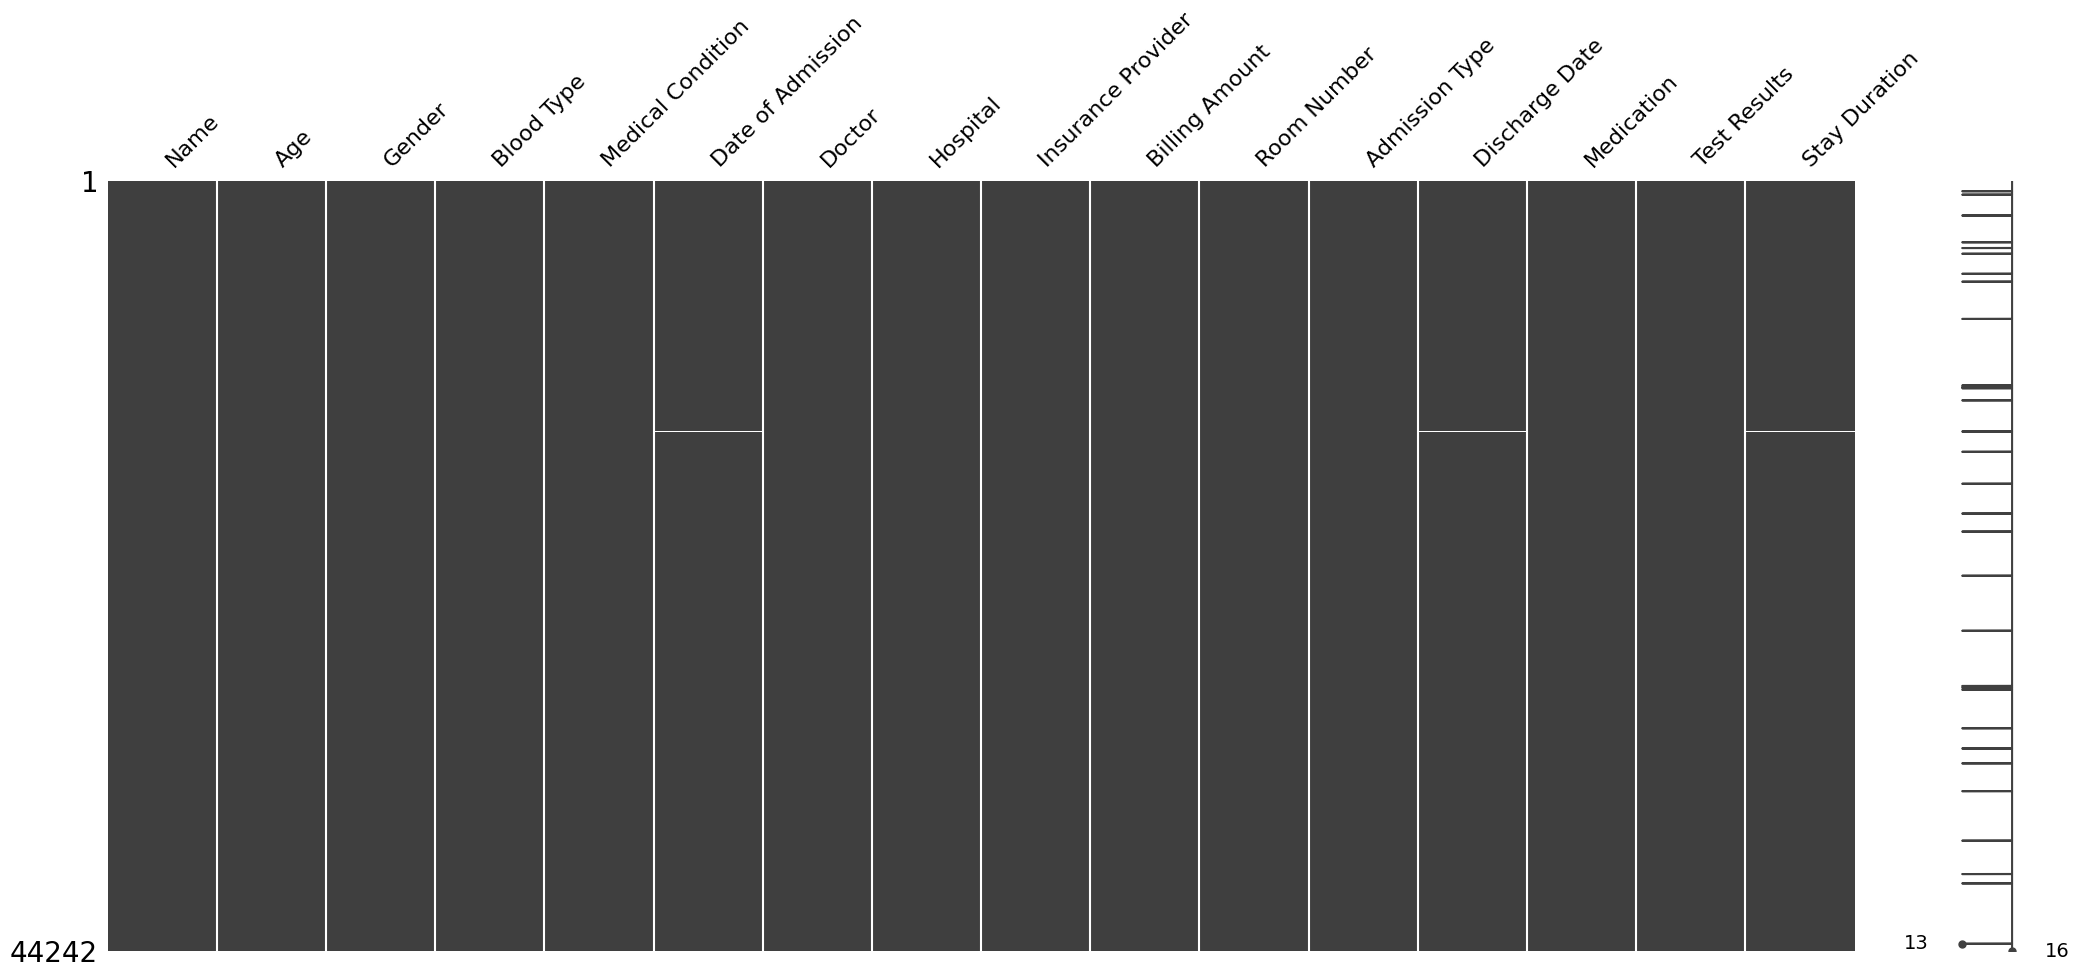

C:\Users\User\AppData\Local\Temp\ipykernel_19756\2506423834.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')
C:\Users\User\AppData\Local\Temp\ipykernel_19756\2506423834.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')


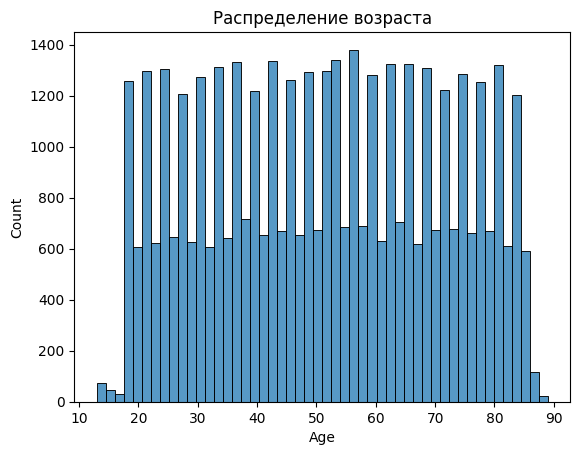

count    44242.000000
mean        15.498056
std          8.402797
min          1.000000
25%          8.000000
50%         15.000000
75%         23.000000
max         30.000000
Name: Stay Duration, dtype: float64


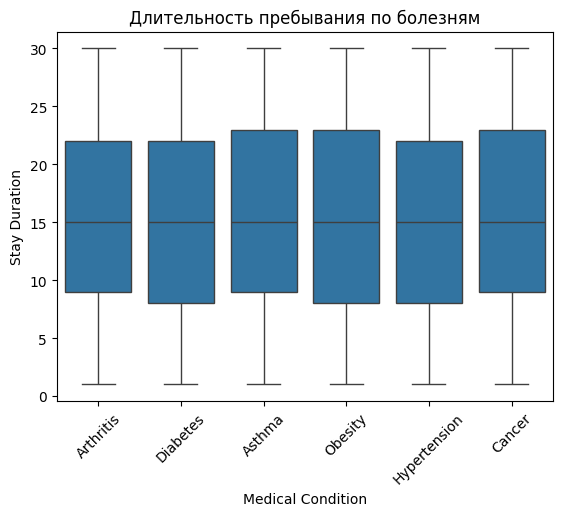

Medical Condition
Diabetes        7449
Hypertension    7428
Arthritis       7369
Obesity         7353
Cancer          7331
Asthma          7312
Name: count, dtype: int64


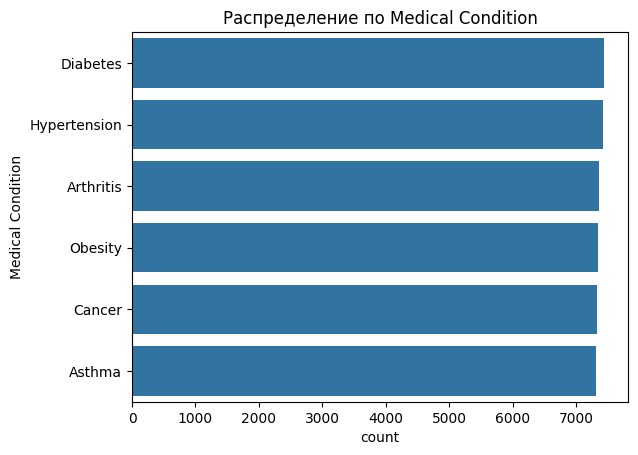

Gender
male       22233
female     21598
unknown      411
Name: count, dtype: int64


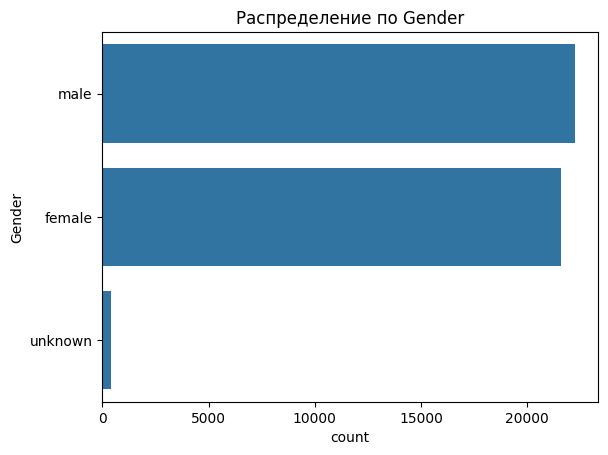

Blood Type
A+     5845
O+     5802
B+     5626
AB+    5474
A-     5450
B-     5433
AB-    5337
O-     5275
Name: count, dtype: int64


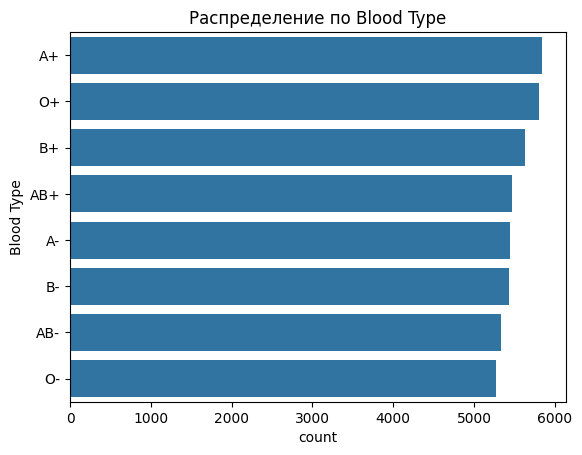

Admission Type
Elective     15634
Emergency    14334
Urgent       14274
Name: count, dtype: int64


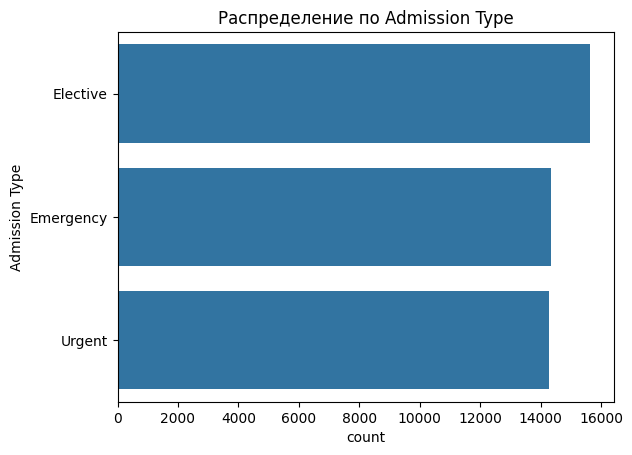

Insurance Provider
Cigna               9012
UnitedHealthcare    8899
Medicare            8861
Blue Cross          8845
Aetna               8625
Name: count, dtype: int64


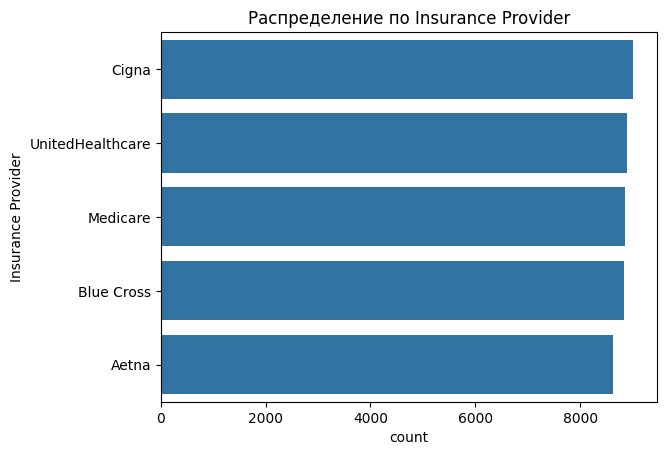

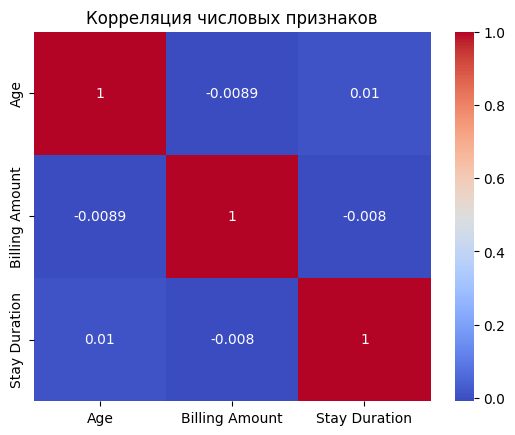

In [33]:
# Общая информация
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

#print(Tnew.info())

# Проверка пропусков
msno.matrix(Tnew)
plt.show()



#Дозаполним остатки
def fill_missing_values(df):
    # Числовые колонки — медиана
    num_cols = ['Age', 'Billing Amount', 'Stay Duration']
    for col in num_cols:
        if col in df.columns:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)

    # Категориальные — mode
    cat_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Insurance Provider', 'Medication', 'Test Results']
    for col in cat_cols:
        if col in df.columns:
            mode_val = df[col].mode().iloc[0]
            df[col] = df[col].fillna(mode_val)
    
    # Для дат можно либо forward fill
    date_cols = ['Date of Admission', 'Discharge Date']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[col] = df[col].fillna(method='ffill')
    
    return df

Tnew = fill_missing_values(Tnew)


# Распределение возраста
sns.histplot(Tnew['Age'], bins=50)
plt.title('Распределение возраста')
plt.show()

# Статистика по Stay Duration
print(Tnew['Stay Duration'].describe())
sns.boxplot(x='Medical Condition', y='Stay Duration', data=Tnew)
plt.title('Длительность пребывания по болезням')
plt.xticks(rotation=45)
plt.show()

# Частоты категориальных признаков
categorical_cols = ['Medical Condition', 'Gender', 'Blood Type', 'Admission Type', 'Insurance Provider']
for col in categorical_cols:
    print(Tnew[col].value_counts())
    sns.countplot(y=col, data=Tnew, order=Tnew[col].value_counts().index)
    plt.title(f'Распределение по {col}')
    plt.show()

# Корреляции по числовым признакам
numeric_cols = ['Age', 'Billing Amount', 'Stay Duration']
sns.heatmap(Tnew[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция числовых признаков')
plt.show()

# Распределение между группами крови и болезнями
Не смотря на равномерность типов крови и числа заболевших попробуем скоррелировать данные между группой крови и болезнями.
Исходя из этого можно выдвинуть гипотезу, что
*1. что среди A+(II+) больше диабетиков, людей страдающих ожирением и раком, 
*2. А среди O-(I-) меньше всех диабетиков, страдающих ожирением и артиртом
Но результат не является статистически значимым. (связь не сильная)


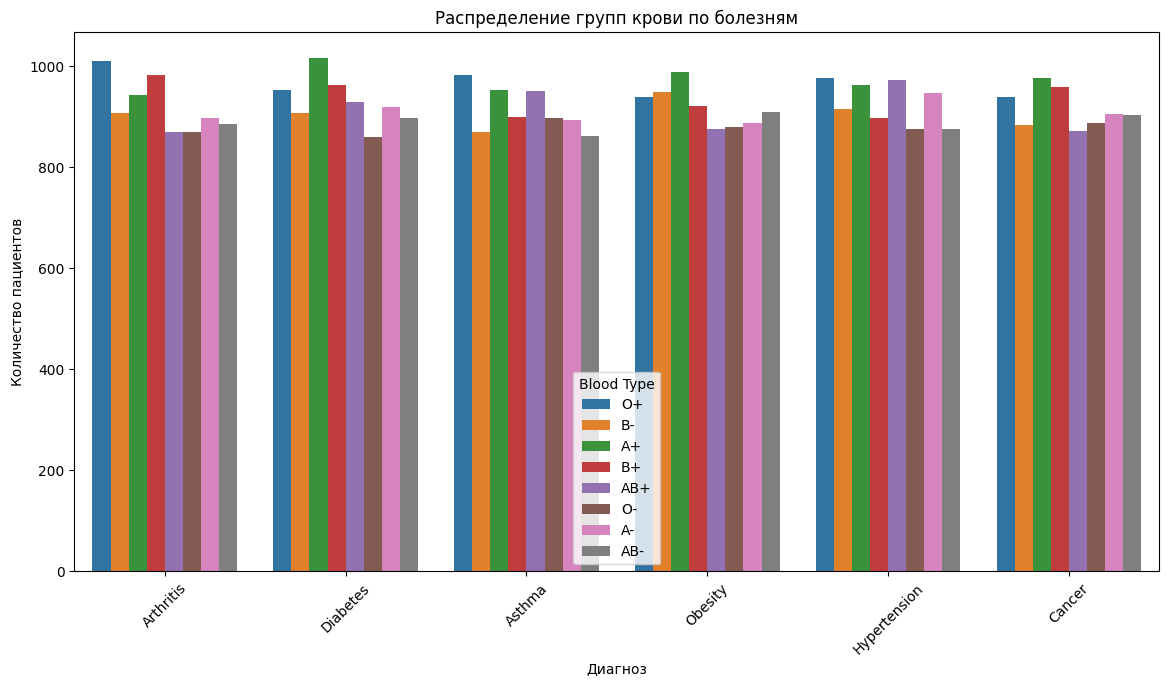

χ²-statistic: 33.39
p-value: 0.5460
Связь между болезнью и группой крови не значима на уровне 0.05.


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,7))
sns.countplot(data=Tnew, x='Medical Condition', hue='Blood Type')
plt.title('Распределение групп крови по болезням')
plt.xticks(rotation=45)
plt.xlabel('Диагноз')
plt.ylabel('Количество пациентов')
#plt.legend(title='Группа крови', loc='upper right', bbox_to_anchor=(1, 1))

#plt.legend(title='Группа крови', loc='upper right', bbox_to_anchor=(1, 1), fontsize='small', ncol=9)
plt.show()


from scipy.stats import chi2_contingency

# Контингентная таблица
cont_table = pd.crosstab(Tnew['Blood Type'], Tnew['Medical Condition'])

# Хи-квадрат тест
chi2, p, dof, expected = chi2_contingency(cont_table)

print(f"χ²-statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("Есть статистически значимая связь между болезнью и группой крови.")
else:
    print("Связь между болезнью и группой крови не значима на уровне 0.05.")

# Корреляция между группами возрастов относительно болезней, страховых, лекарств,
К сожалению, эти гипотезы так же не принесли зависимых результатов

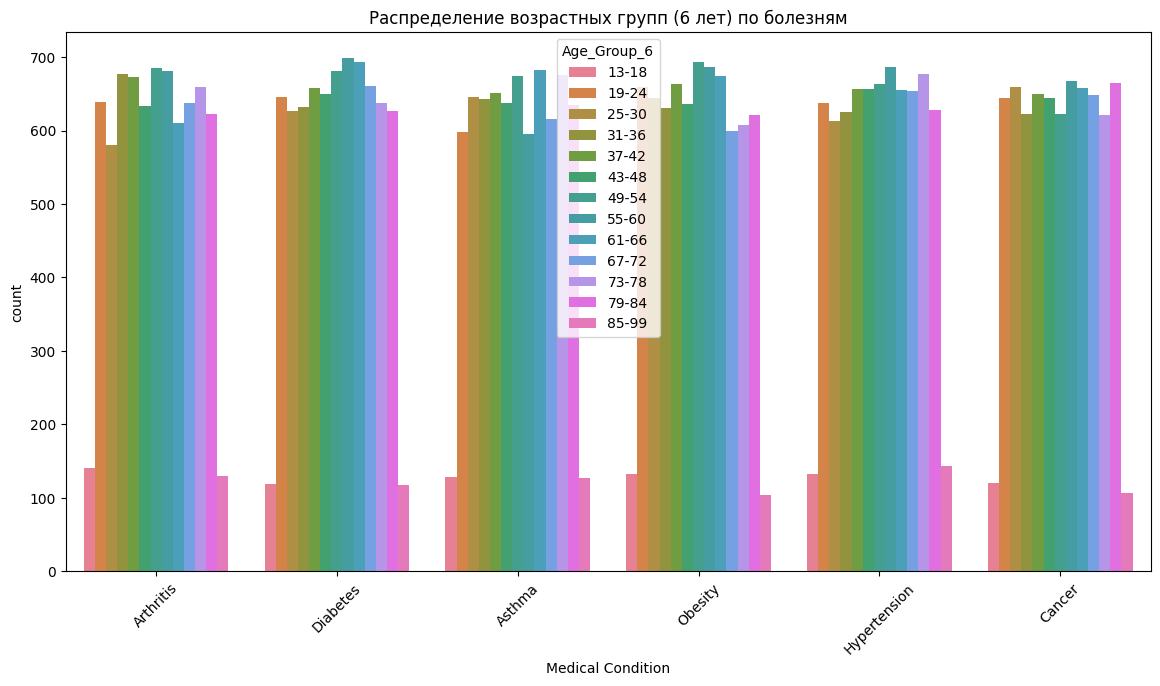

Chi2 для возрастными группами и типами болезней: 59.01
P-value для возрастными группами и типами болезней: 0.5118
Связь между возрастными группами и типами болезней не значима.



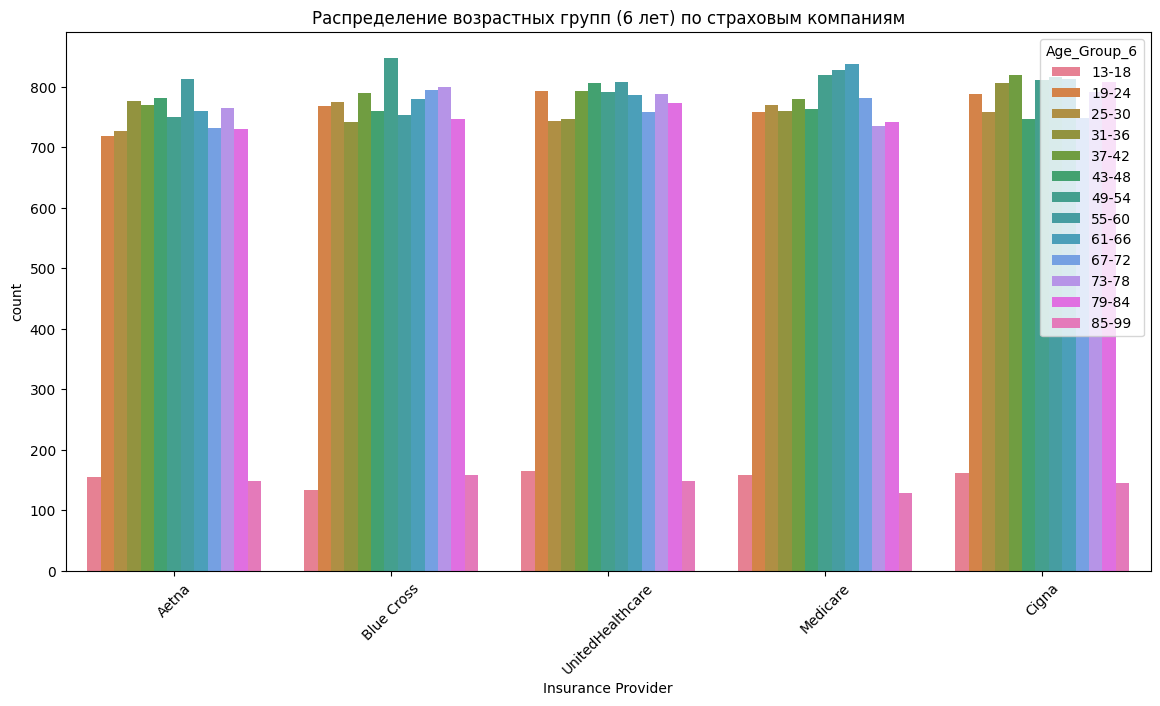

Chi2 для возрастными группами и страховыми: 40.41
P-value для возрастными группами и страховыми: 0.7734
Связь между возрастными группами и страховыми не значима.



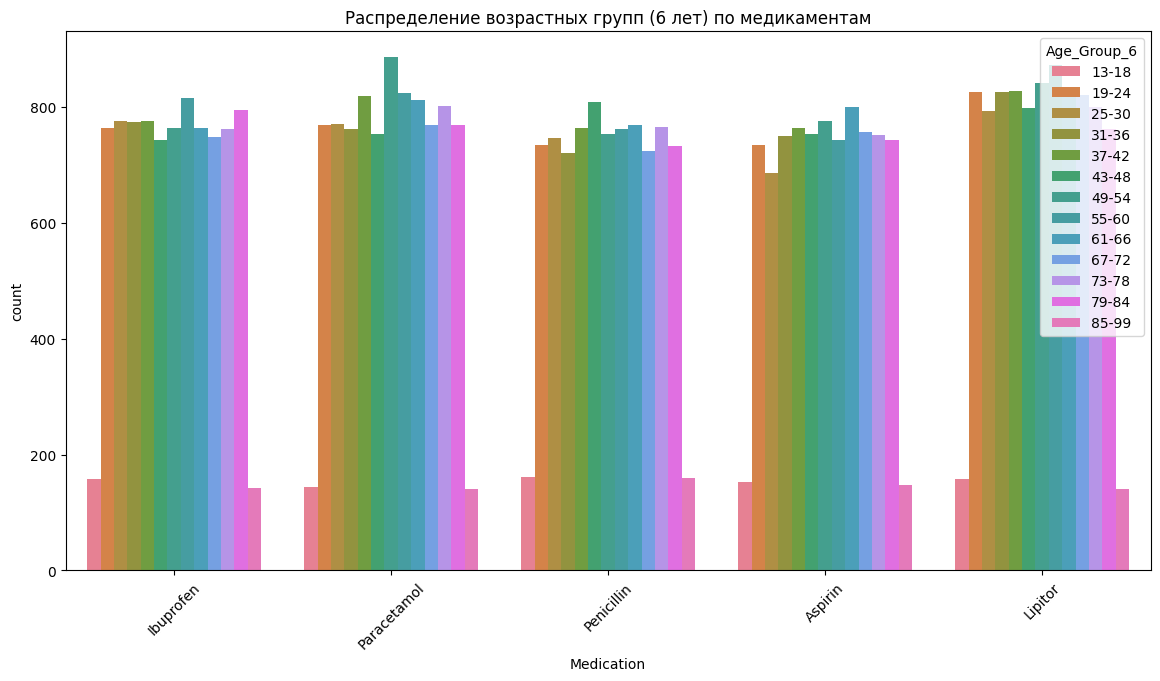

Chi2 для возрастными группами и медикаментами: 40.06
P-value для возрастными группами и медикаментами: 0.7856
Связь между возрастными группами и медикаментами не значима.



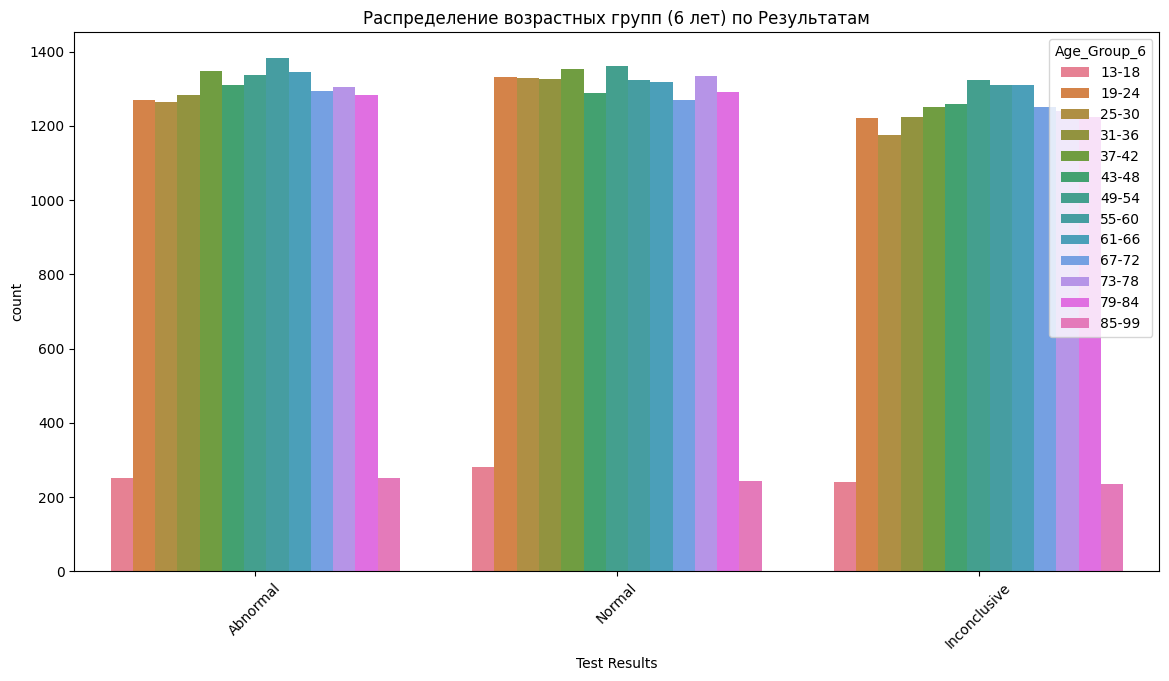

Chi2 для возрастными группами и результатами: 13.88
P-value для возрастными группами и результатами: 0.9494
Связь между возрастными группами и результатами не значима.



In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Создаем возрастные группы с шагом 6 лет
bins = list(range(13, 90, 6)) + [100]
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
Tnew['Age_Group_6'] = pd.cut(Tnew['Age'], bins=bins, labels=labels, right=False)

# Функция для теста и вывода результата
def chi_square_test(df, col1, col2, title):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Chi2 для {title}: {chi2:.2f}")
    print(f"P-value для {title}: {p:.4f}")
    if p < 0.05:
        print(f"Статистически значимая связь между {title}.\n")
    else:
        print(f"Связь между {title} не значима.\n")

# График: распределение возрастных групп по болезням
plt.figure(figsize=(14,7))
sns.countplot(data=Tnew, x='Medical Condition', hue='Age_Group_6')
plt.title('Распределение возрастных групп (6 лет) по болезням')
plt.xticks(rotation=45)
plt.show()
chi_square_test(Tnew, 'Age_Group_6', 'Medical Condition', 'возрастными группами и типами болезней')

# График: распределение возрастных групп по страховым компаниям
plt.figure(figsize=(14,7))
sns.countplot(data=Tnew, x='Insurance Provider', hue='Age_Group_6')
plt.title('Распределение возрастных групп (6 лет) по страховым компаниям')
plt.xticks(rotation=45)
plt.show()
chi_square_test(Tnew, 'Age_Group_6', 'Insurance Provider', 'возрастными группами и страховыми')

# График: распределение возрастных групп по медикаментам
plt.figure(figsize=(14,7))
sns.countplot(data=Tnew, x='Medication', hue='Age_Group_6')
plt.title('Распределение возрастных групп (6 лет) по медикаментам')
plt.xticks(rotation=45)
plt.show()
chi_square_test(Tnew, 'Age_Group_6', 'Medication', 'возрастными группами и медикаментами')

# График: распределение возрастных групп по медикаментам
plt.figure(figsize=(14,7))
sns.countplot(data=Tnew, x='Test Results', hue='Age_Group_6')
plt.title('Распределение возрастных групп (6 лет) по Результатам')
plt.xticks(rotation=45)
plt.show()
chi_square_test(Tnew, 'Age_Group_6', 'Test Results', 'возрастными группами и результатами')



# Связь между полом и заболеваниями, а так же между возрастом и счетом

Корреляция Спирмена: -0.008104559171215747
P-value: 0.08974617064891545
Связь между полом и диагнозом не значима.


C:\Users\User\AppData\Local\Temp\ipykernel_19756\4143729989.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tnew_filtered['Gender_Num'] = Tnew_filtered['Gender'].map({'female': 0, 'male': 1})
C:\Users\User\AppData\Local\Temp\ipykernel_19756\4143729989.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tnew_filtered['Condition_Code'] = le.fit_transform(Tnew_filtered['Medical Condition'])


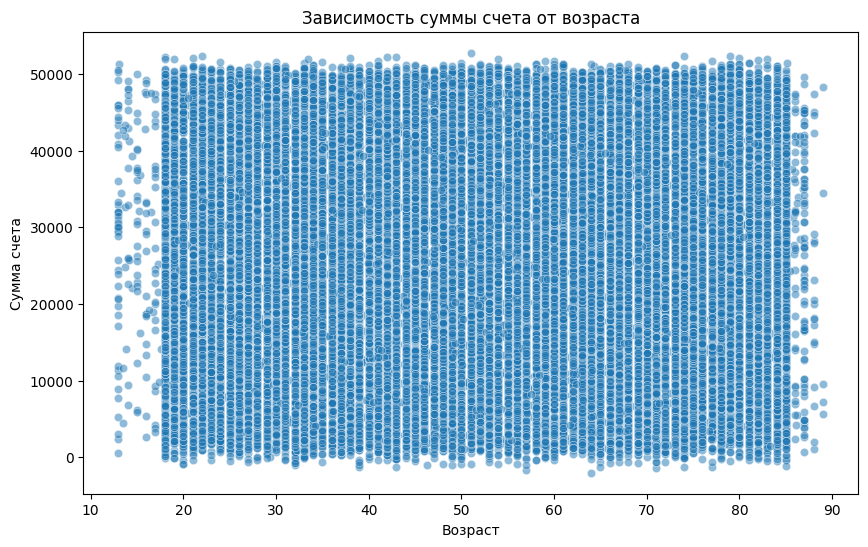

Коэффициент корреляции Пирсона: -0.009 (p-value=0.0617)
Коэффициент корреляции Спирмена: -0.009 (p-value=0.0664)


In [36]:
# Удаляем записи с неизвестным полом
Tnew_filtered = Tnew[Tnew['Gender'].isin(['male', 'female'])]

# Преобразуем пол в числовой формат
Tnew_filtered['Gender_Num'] = Tnew_filtered['Gender'].map({'female': 0, 'male': 1})

# Кодируем диагнозы
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Tnew_filtered['Condition_Code'] = le.fit_transform(Tnew_filtered['Medical Condition'])

# Запускаем корреляционный анализ Спирмена
from scipy.stats import spearmanr
corr, p_value = spearmanr(Tnew_filtered['Gender_Num'], Tnew_filtered['Condition_Code'])

print(f"Корреляция Спирмена: {corr}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Статистически значимая связь между полом и диагнозом")
else:
    print("Связь между полом и диагнозом не значима.")


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

data = Tnew.dropna(subset=['Age', 'Billing Amount'])

# Визуализация зависимости
plt.figure(figsize=(10,6))
sns.scatterplot(x='Age', y='Billing Amount', data=data, alpha=0.5)
plt.title('Зависимость суммы счета от возраста')
plt.xlabel('Возраст')
plt.ylabel('Сумма счета')
plt.show()

# Расчет корреляций
pearson_corr, pearson_p = pearsonr(data['Age'], data['Billing Amount'])
spearman_corr, spearman_p = spearmanr(data['Age'], data['Billing Amount'])

print(f"Коэффициент корреляции Пирсона: {pearson_corr:.3f} (p-value={pearson_p:.4f})")
print(f"Коэффициент корреляции Спирмена: {spearman_corr:.3f} (p-value={spearman_p:.4f})")

#

Во входных данных не найдена зависмость, более того одними и теми же средствами лечат от рака до ожирения, распределения групп крови как на подбор одинаковое, как и количество  людей в страховых, теперь на нескоррелированных данных попробуем обучить регрессионную модель 

# Обучение модели регрессии
Возьмем колонки которые имеют смысл: ['Age', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results'] и преобразуем категориальные признаки через *one hot encoder* https://habr.com/ru/articles/666234/?ysclid=mhb06jslxx985402113
В качестве критерия возмем СКО относительно прогнозируемой модели. В качестве выходных метрик смотрим абсолютную ошибку, $R^2$, и размах значений

In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Загрузка данных
train = Tnew  # ваши тренировочные данные
test = pd.read_csv("test.csv")  # тестовая выборка

# Предобработка (пример): отделяем признаки и целевую переменную
columns_needed = ['Age', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']

X_train = train[columns_needed]
X_test = test[columns_needed]
y_train = train['Billing Amount']
X_test = test.drop(columns=['Billing Amount'])
y_test = test['Billing Amount']

# Преобразование категориальных признаков (пример: one-hot)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Согласуем колонки теста и трейна (если появились пропуски)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Обучение модели XGBoost
model = XGBRegressor(random_state=42, n_jobs=-1, eval_metric='rmse')
model.fit(X_train, y_train)

# Предсказания на тесте
y_pred = model.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
peak2peak = np.ptp(y_test - y_pred)  # размах ошибок

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.3f}")
print(f"Peak2Peak error: {peak2peak:.2f}")


from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np

model = XGBRegressor(random_state=42, n_jobs=-1, eval_metric='rmse')
scores_mae = -cross_val_score(model, X_train, y_train, cv=150, scoring='neg_mean_absolute_error')
scores_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=150, scoring='neg_mean_squared_error'))
scores_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

print(f"MAE (кросс-валидация): {scores_mae.mean():.2f} ± {scores_mae.std():.2f}")
print(f"RMSE (кросс-валидация): {scores_rmse.mean():.2f} ± {scores_rmse.std():.2f}")
print(f"R^2 (кросс-валидация): {scores_r2.mean():.3f} ± {scores_r2.std():.3f}")

# Выбор нужных столбцов
#columns_needed = ['Age', 'BloodType', 'MedicalCondition', 'InsuranceProvider', 'AdmissionType', 'Medication', 'TestResults']

X_train = train[columns_needed]
y_train = train['Billing Amount']

X_test = test[columns_needed]
y_test = test['Billing Amount']

categorical_features = ['Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']
numeric_features = ['Age']

# Создаем препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Пайплайн предобработки и модели
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42, n_jobs=-1))
])

# Обучаем
model_pipeline.fit(X_train, y_train)

# Предсказываем
y_pred = model_pipeline.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
peak2peak = np.ptp(y_test - y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.3f}")
print(f"Peak2Peak error: {peak2peak:.2f}")


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 12429.88
RMSE: 14514.02
R^2: -0.059
Peak2Peak error: 75594.29
MAE (кросс-валидация): 12466.40 ± 440.11
RMSE (кросс-валидация): 14506.45 ± 412.90
R^2 (кросс-валидация): -0.050 ± 0.005
MAE: 12429.88
RMSE: 14514.02
R^2: -0.059
Peak2Peak error: 75594.29


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Как и предполагалось корреляция отсутвует. 
# Задача классификации
Для задачи классификации (предсказания Medical Condition или Insurance Provider)  используем модель LightGBM (Light Gradient Boosted Machine) https://habr.com/ru/companies/skillfactory/articles/530594/?ysclid=mhb0sn8z63411212312 
метрики используем стандартные классический Recall, precision, accuracy и F мера. Так же приведем Confusion Matrix
Accuracy: 0.182
Precision (macro): 0.182
Recall (macro): 0.182
F1-score (macro): 0.181


In [51]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split

# Выбираем признаки включая BillingAmount
columns_needed = ['Age', 'Blood Type', 'Admission Type', 'Medication', 'Test Results', 'Billing Amount']
target_column = 'Medical Condition'  # или 'InsuranceProvider'

X = train[columns_needed]
y = train[target_column]

# Кодируем категориальные признаки как категории (LightGBM умеет работать с ними напрямую)
categorical_features = ['Blood Type', 'Admission Type', 'Medication', 'Test Results']
for col in categorical_features:
    X[col] = X[col].astype('category')

# Кодируем целевую переменную
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Разделяем выборку
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Инициализация и обучение модели
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train, categorical_feature=categorical_features)

# Предсказания
y_pred = model.predict(X_val)

# Метрики
accuracy = accuracy_score(y_val, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average='macro')
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1-score (macro): {f1_score:.3f}")
print("Confusion Matrix:")
print(conf_matrix)


C:\Users\User\AppData\Local\Temp\ipykernel_19756\311416596.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
C:\Users\User\AppData\Local\Temp\ipykernel_19756\311416596.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
C:\Users\User\AppData\Local\Temp\ipykernel_19756\311416596.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 35393, number of used features: 6
[LightGBM] [Info] Start training from score -1.792410
[LightGBM] [Info] Start training from score -1.800072
[LightGBM] [Info] Start training from score -1.797512
[LightGBM] [Info] Start training from score -1.781611
[LightGBM] [Info] Start training from score -1.784468
[LightGBM] [Info] Start training from score -1.794617
Accuracy: 0.182
Precision (macro): 0.182
Recall (macro): 0.182
F1-score (macro): 0.181
Confusion Matrix:
[[245 244 225 261 236 263]
 [224 283 207 271 231 246]
 [203 257 235 253 247 271]
 [226 264 166 302 252 280]
 [212 226 215 289 248 296]
 [247